In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, cross_val_predict, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as IMBPipeline
import seaborn as sns

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


In [2]:
df_train = pd.read_csv("/Users/dana/Desktop/AHI/01_PAML/Project/scr/Part_2/train_pca_data_imputed.csv")
df_val   = pd.read_csv("/Users/dana/Desktop/AHI/01_PAML/Project/scr/Part_2/val_pca_data_imputed.csv")

target = "er"

X_train = df_train.drop(columns=[target]).values
y_train = df_train[target].values

X_val = df_val.drop(columns=[target]).values
y_val = df_val[target].values


In [ ]:
# rf_smote pipeline
rf_smote = IMBPipeline(steps=[
    ("smote", SMOTE(random_state=RANDOM_SEED)),
    ("scaler", StandardScaler()),
    ("rf", RandomForestClassifier(
        n_estimators=300, # for biological gene expression tasks, 200–500 trees is standard
        max_depth=None,
        min_samples_split=2,
        class_weight=None,
        random_state=RANDOM_SEED))])

In [ ]:
# Evaluate on held-out validation set
rf_smote.fit(X_train, y_train)

y_pred = rf_smote.predict(X_val)
y_proba = rf_smote.predict_proba(X_val)[:, 1]

def metrics(y_true, y_pred, y_proba):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
        "roc_auc": roc_auc_score(y_true, y_proba)
    }

val_metrics = metrics(y_val, y_pred, y_proba)
pd.DataFrame([val_metrics])


,accuracy,precision,recall,f1,roc_auc
0,0.919355,0.913793,1.0,0.954955,0.91195


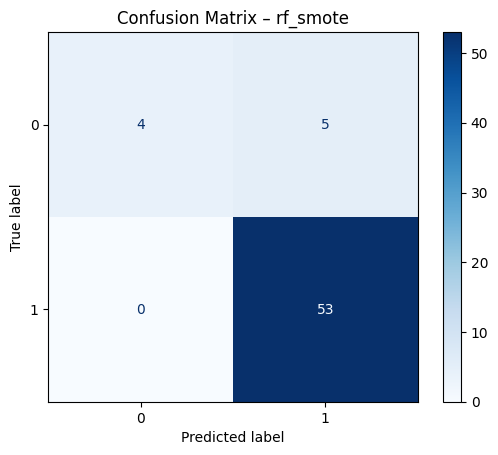

In [12]:
# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix – rf_smote")
plt.savefig("Confusion_Matrix_rf_smote.png", dpi=300)
plt.show()


In [ ]:
# 10-fold stratified cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)

cv_pred = cross_val_predict(
    rf_smote, X_train, y_train,
    cv=cv,
    method="predict"
)

cv_pred_proba = cross_val_predict(
    rf_smote, X_train, y_train,
    cv=cv,
    method="predict_proba"
)[:, 1]

cv_metrics = metrics(y_train, cv_pred, cv_pred_proba)
pd.DataFrame([cv_metrics])


,accuracy,precision,recall,f1,roc_auc
0,0.929348,0.95,0.968153,0.958991,0.949988


In [ ]:
# Bootstrapped confidence intervals
def bootstrap_ci(model, X, y, n_boot=200):
    stats = {"accuracy": [], "recall": [], "f1": []}

    for i in range(n_boot):
        idx = np.random.choice(len(X), len(X), replace=True)
        Xb, yb = X[idx], y[idx]

        model.fit(Xb, yb)
        pred = model.predict(X_val)

        stats["accuracy"].append(accuracy_score(y_val, pred))
        stats["recall"].append(recall_score(y_val, pred))
        stats["f1"].append(f1_score(y_val, pred))

    ci = {
        k: (np.percentile(v, 2.5), np.percentile(v, 97.5))
        for k, v in stats.items()
    }
    return ci

ci_results = bootstrap_ci(rf_smote, X_train, y_train)
ci_results


{'accuracy': (np.float64(0.8709677419354839), np.float64(0.9354838709677419)),
 'recall': (np.float64(0.9811320754716981), np.float64(1.0)),
 'f1': (np.float64(0.9297932330827068), np.float64(0.9636363636363636))}

In [ ]:
# Sensitivity analysis to random seed
seeds = [0, 21, 42, 77, 123, 2025]
seed_results = []

for seed in seeds:
    model = IMBPipeline(steps=[
        ("smote", SMOTE(random_state=seed)),
        ("scaler", StandardScaler()),
        ("rf", RandomForestClassifier(random_state=seed, n_estimators=300))
    ])
    
    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    proba = model.predict_proba(X_val)[:, 1]

    m = metrics(y_val, pred, proba)
    m["seed"] = seed
    seed_results.append(m)

pd.DataFrame(seed_results)


,accuracy,precision,recall,f1,roc_auc,seed
0,0.903226,0.912281,0.981132,0.945455,0.921384,0
1,0.919355,0.913793,1.000000,0.954955,0.918239,21
2,0.919355,0.913793,1.000000,0.954955,0.911950,42
3,0.919355,0.913793,1.000000,0.954955,0.907757,77
4,0.919355,0.913793,1.000000,0.954955,0.895178,123
5,0.919355,0.913793,1.000000,0.954955,0.914046,2025


/Users/dana/anaconda3/envs/ahi/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
15 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/dana/anaconda3/envs/ahi/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/dana/anaconda3/envs/ahi/lib/python3.13/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/dana/anaconda3/envs/ahi/lib/python3.13/site-packages/i

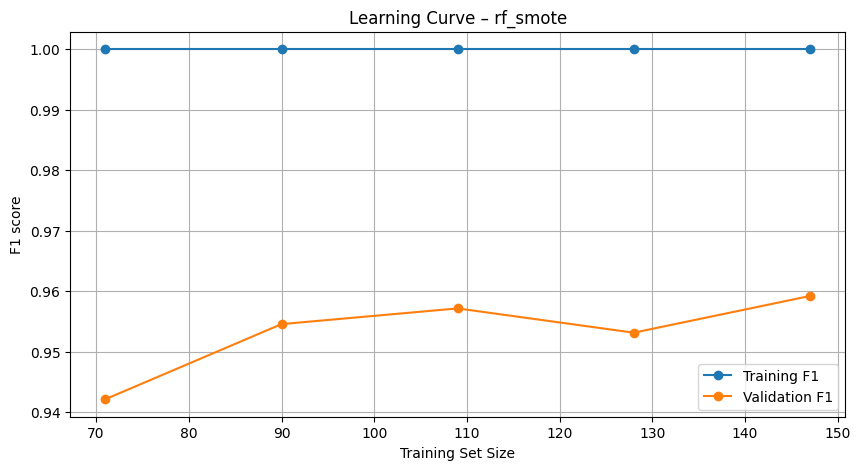

In [11]:
# Learning curve (data sufficiency check)

train_sizes, train_scores, val_scores = learning_curve(
    rf_smote,
    X_train, y_train,
    cv=5,
    scoring="f1",
    train_sizes=np.linspace(0.1, 1.0, 8),
    random_state=RANDOM_SEED
)

plt.figure(figsize=(10,5))
plt.plot(train_sizes, train_scores.mean(axis=1), marker="o", label="Training F1")
plt.plot(train_sizes, val_scores.mean(axis=1), marker="o", label="Validation F1")
plt.title("Learning Curve – rf_smote")
plt.xlabel("Training Set Size")
plt.ylabel("F1 score")
plt.legend()
plt.grid()
plt.savefig("Learning_Curve_rf_smote.png", dpi=300)
plt.show()